# Model-based Machine Learning Project: Modifying Deep Q-Networks in Reinforcement Learning

## Test Random Environment with OpenAI Gym 
This code uses the OpenAI Gym library to create an environment for the CartPole-v1 game. It then runs 20 episodes of the game, where in each episode the agent randomly selects actions and tries to balance a pole on a cart while collecting rewards. The score of each episode is printed at the end, and the environment is closed. 

In [52]:
import csv
import math
import functools
import gymnasium as gym
import huggingface_hub
import matplotlib
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import numpy as np
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import pandas as pd
import pathlib
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoGuideList, AutoMultivariateNormal
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO, Trace_ELBO
from pyro.nn import PyroModule, PyroSample
from pyro.optim import Adam, ClippedAdam
import random
import re
import seaborn as sns
import string
import tokenizers
import torch
import torch.distributions.constraints as constraints
import torch.nn as nn
import torch.optim as optim
from torch import nn
# from torch.nn import ModuleList
# from torch.nn.functional import F
from torch.distributions import constraints
import tqdm
import transformers
from typing import Any, Dict, List, Optional, Tuple
import zipfile
from IPython import display
from collections import deque, namedtuple
from itertools import count
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pyro.distributions import Laplace
import plotly.graph_objs as go

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elysi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elysi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


c:\Users\elysi\anaconda3\envs\cartpole2\Lib\site-packages\gym\core.py:317: DeprecationWarning:

WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.

c:\Users\elysi\anaconda3\envs\cartpole2\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning:

WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.

c:\Users\elysi\anaconda3\envs\cartpole2\Lib\site-packages\gym\core.py:317: DeprecationWarning:

WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.

c:\Users\elysi\anaconda3\envs\cartpole2\Lib\site-packages\gym\utils\passive_env_checker.py:241: D

Episode:1 Score:15.0
Episode:2 Score:15.0
Episode:3 Score:16.0
Episode:4 Score:14.0
Episode:5 Score:26.0
Episode:6 Score:18.0
Episode:7 Score:34.0
Episode:8 Score:26.0
Episode:9 Score:27.0
Episode:10 Score:14.0
Episode:11 Score:28.0
Episode:12 Score:11.0
Episode:13 Score:12.0
Episode:14 Score:15.0
Episode:15 Score:22.0
Episode:16 Score:18.0
Episode:17 Score:30.0
Episode:18 Score:24.0
Episode:19 Score:17.0
Episode:20 Score:10.0


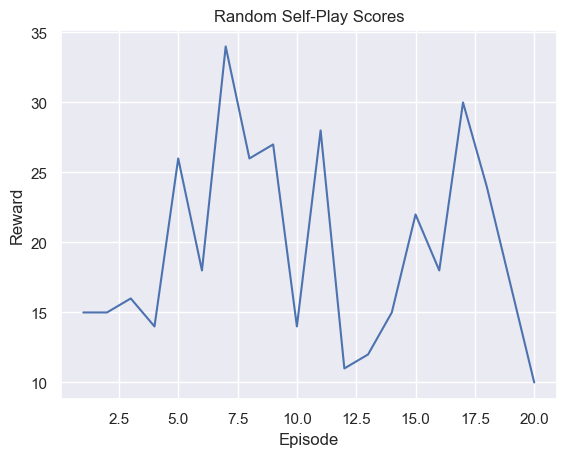

In [62]:
import gym
import matplotlib.pyplot as plt

def plot_episodes_rewards(episodes, rewards):
    plt.plot(episodes, rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Random Self-Play Scores")
    plt.show()

env = gym.make("CartPole-v1")
episodes = 20
rewards = []

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, _ = env.step(action)
        score += reward
        # env.render()
    
    rewards.append(score)
    print('Episode:{} Score:{}'.format(episode, score))
    
env.close()

plot_episodes_rewards(range(1, episodes+1), rewards)


## Creating Replay Memory and Transition classes for DQN algorithm in PyTorch.

In reinforcement learning, the DQN (Deep Q-Network) algorithm uses experience replay memory to store the transitions that the agent observes. The ReplayMemory class implements a cyclic buffer of bounded size that holds the transitions observed recently, and a sample() method for selecting a random batch of transitions for training. The Transition class is a named tuple representing a single transition in the environment, essentially mapping (state, action) pairs to their (next_state, reward) result.

In [54]:
env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\elysi\anaconda3\envs\cartpole2\Lib\site-packages\gym\core.py:317: DeprecationWarning:

WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.

c:\Users\elysi\anaconda3\envs\cartpole2\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning:

WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.

c:\Users\elysi\anaconda3\envs\cartpole2\Lib\site-packages\gym\core.py:317: DeprecationWarning:

WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.



In [55]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Defining DQN that integrates PGM with NN
The given code defines a Deep Q-Network (DQN) using PyTorch and Pyro, which combines a probabilistic graphical model (PGM) with a neural network. The architecture of the DQN is a Feed-Forward Neural Network (FFNN) with three fully connected layers, which takes in the state of the environment as input and outputs the Q-values for each possible action. The FFNN is defined as a PyroModule, which allows for the incorporation of probabilistic programming into the model. The PyroModule includes three linear layers with a specified number of input, hidden, and output neurons respectively, and a hyperbolic tangent activation function. The DQN class includes the FFNN as a submodule and has a forward method which passes the input through the FFNN and returns the output. The final layer of the FFNN outputs the predicted mean Q-values which are then used to sample from a Normal distribution with a fixed variance of 0.1, to calculate the loss for the backpropagation step during training. The given code follows a PGM of the form: yn = flinear(xn) + fnnet(un) + ϵ, where flinear(xn) = β.Txn and fnnet(un) is a DNN with parameters denoted by θ (i.e. θ includes all bias parameters and weights of the DNN). The updated generative process involves drawing local linear coefficients β ∼ N (β|0, λI), local DNN parameters θ ∼ N (θ|0, τ I), global parameters, and for the nth observation, drawing target yn ∼ N (yn|flinear(xn) + fnnet(un), σ^2).

<img src="mbml1.png" width="600" height="450" />


<img src="mbml2.png" width="600" height="450" />


<img src="mbml3.png" width="600" height="450" />


In [56]:
from pyro.distributions import Normal
class FFNN(PyroModule):
    def __init__(self, n_in, n_hidden, n_out, n_levels, b_global, c_global, b_l, c_l, word_embedding):
        super(FFNN, self).__init__()

        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(Normal(0., 1.).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(Normal(0., 1.).expand([n_out, n_hidden]).to_event(2))

        # Priors
        self.b_global = b_global
        self.c_global = c_global
        self.b_l = b_l
        self.c_l = c_l

        # Activation functions
        self.tanh = nn.Tanh()

        # Hierarchical model
        self.beta_global = PyroSample(Normal(0., self.b_global).expand([n_hidden, n_in]).to_event(2))
        self.theta_global = PyroSample(Normal(0., self.c_global).expand([n_hidden, n_hidden]).to_event(2))
        self.beta_l = [PyroSample(Normal(self.beta_global, self.b_l).expand([n_hidden, n_in]).to_event(2)) for _ in range(n_levels)]
        self.theta_l = [PyroSample(Normal(self.theta_global, self.c_l).expand([n_hidden, n_hidden]).to_event(2)) for _ in range(n_levels)]

        self.word_embedding = word_embedding
        self.word_layer = PyroModule[nn.Linear](len(word_embedding), n_hidden)
        self.word_layer.weight = PyroSample(Normal(0., 1.).expand([n_hidden, len(word_embedding)]).to_event(2))

        self.to(device)  # move the model to the desired device

    def forward(self, X, level_idx=None, y=None):
        if level_idx is not None:
            beta = self.beta_l[level_idx]
            theta = self.theta_l[level_idx]
        else:
            beta = self.beta_global
            theta = self.theta_global

        X = self.tanh(torch.matmul(beta, X.t()).t())

        # Apply word_embedding layer
        word_embed = self.tanh(torch.matmul(self.word_layer.weight, self.word_embedding.t()).t())
        X = X + word_embed

        X = self.tanh(torch.matmul(theta, X.t()).t())
        X = self.out_layer(X)
        prediction_mean = X.squeeze(-1)
        with pyro.plate("observations"):
            y = pyro.sample("obs", Normal(prediction_mean, 0.1), obs=y)

        return y


class DQN(PyroModule):
    def __init__(self, n_observations, n_actions, n_levels, b_global, c_global, b_l, c_l, word_embedding):
        super(DQN, self).__init__()

        self.ffnn = FFNN(n_observations, 128, n_actions, n_levels, b_global, c_global, b_l, c_l, word_embedding).to(device)

    def forward(self, x, level_idx=None):
        return self.ffnn(x, level_idx)


## Defining DQN Network from PyTorch Tutorials as Comparison to our Model 

In [57]:
class ComparisonDQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(ComparisonDQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Training, Hyperparameters, and Utilities
This code block defines some hyperparameters and utilities for training a Deep Q-Network (DQN) to solve the CartPole-v1 environment from OpenAI Gym. The hyperparameters include the batch size, discount factor, initial and final values of epsilon for an epsilon-greedy policy, epsilon decay rate, target network update rate, and learning rate for the AdamW optimizer. The utilities include a function to select actions based on the epsilon-greedy policy, and a helper function to plot the duration of episodes and a moving average over the last 100 episodes. The code also instantiates the policy and target networks, their optimizer, and a replay memory.

In [58]:
# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
B_GLOBAL = 1
C_GLOBAL = 1
B_L = 0.1
C_L = 0.1
n_levels = 1

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset()
n_observations = len(state)

# Initialize the policy and target networks for custom DQN
word_embedding = torch.tensor(word_embedding)  # Assuming word_embedding is available
policy_net = DQN(n_observations, n_actions, n_levels=n_levels, b_global=B_GLOBAL, c_global=C_GLOBAL, b_l=B_L, c_l=C_L, word_embedding=word_embedding).to(device)
target_net = DQN(n_observations, n_actions, n_levels=n_levels, b_global=B_GLOBAL, c_global=C_GLOBAL, b_l=B_L, c_l=C_L, word_embedding=word_embedding).to(device)
target_net.load_state_dict(policy_net.state_dict())

# Initialize the policy and target networks for standard DQN for comparison 
comparison_policy_net = ComparisonDQN(n_observations, n_actions).to(device)
comparison_target_net = ComparisonDQN(n_observations, n_actions).to(device)
comparison_target_net.load_state_dict(comparison_policy_net.state_dict())

# Set up the optimizer and replay memory
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
comparison_memory = ReplayMemory(10000)


steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # The second column on the max result is the index of where the max element was
            # found, so we pick the action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


C:\Users\elysi\AppData\Local\Temp\ipykernel_11260\3158630378.py:22: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



## Training Loop 
The code defines a function called optimize_model that performs a single optimization step of the Deep Q-Network (DQN) model. This function takes a random sample of transitions from the replay memory buffer and computes the loss, which is the difference between the expected Q-value and the observed Q-value. The expected Q-value is calculated using the target network, which is updated using a soft update with a hyperparameter TAU. The loss is optimized using an AdamW optimizer with a learning rate of LR. The loss function used is the Huber loss, which is a smoothed version of the L1 loss. The gradients are clipped to avoid the problem of exploding gradients.

In [59]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Random Self Play Function is used to generate random self-play data without training (this is used for comparison against DQN and ComparisonDQN models)

In [60]:
import random

def random_self_play(env, episodes):
    scores = []

    for episode in range(1, episodes + 1):
        state = env.reset()
        done = False
        score = 0

        while not done:
            action = random.randint(0, env.action_space.n - 1)
            next_state, reward, done, _ = env.step(action)
            score += reward

        scores.append(score)
        print(f"Episode: {episode} Score: {score}")

    return scores


This code shows the main training loop where the environment is reset, and the initial state is obtained. An action is then sampled, executed, and the next state and reward (always 1) are observed. The model is then optimized once. When the episode ends, the loop is restarted. The number of episodes is set to 500 if a GPU is available, otherwise, it is set to 500. The model should achieve 500 steps within 500 training episodes. Since training RL agents can be a noisy process, restarting the training process can result in better results if convergence is not observed.

c:\Users\elysi\anaconda3\envs\cartpole2\Lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning:

`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)

c:\Users\elysi\anaconda3\envs\cartpole2\Lib\site-packages\gym\utils\passive_env_checker.py:245: DeprecationWarning:

`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)



Complete


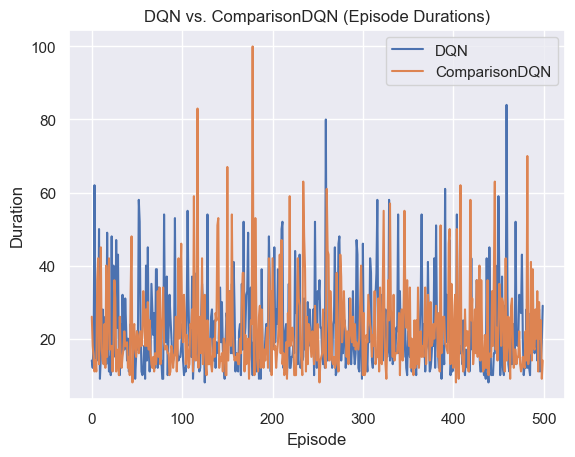

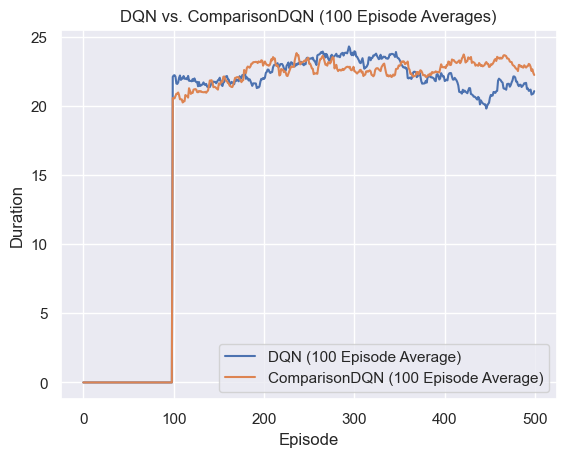

In [61]:
import matplotlib.pyplot as plt
import torch
from itertools import count

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Define the number of episodes
num_episodes = 500

# Initialize episode durations for DQN
episode_durations_dqn = []

# Initialize episode durations for ComparisonDQN
episode_durations_comparison = []

# Initialize duration tensors for calculating 100-episode averages
durations_t_dqn = torch.zeros(num_episodes)
durations_t_comparison = torch.zeros(num_episodes)

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        # DQN
        action = select_action(state)
        observation, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        terminated = done

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        if done:
            episode_durations_dqn.append(t + 1)
            durations_t_dqn[i_episode] = t + 1
            break

    # Soft update of the target network's weights for DQN
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = (
            policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        )
    target_net.load_state_dict(target_net_state_dict)

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        # ComparisonDQN
        comparison_action = select_action(state)
        comparison_observation, comparison_reward, comparison_done, _ = env.step(
            comparison_action.item()
        )
        comparison_reward = torch.tensor([comparison_reward], device=device)

        if comparison_done:
            comparison_next_state = None
        else:
            comparison_next_state = torch.tensor(
                comparison_observation, dtype=torch.float32, device=device
            ).unsqueeze(0)

        # Store the transition in comparison memory
        comparison_memory.push(
            state, comparison_action, comparison_next_state, comparison_reward
        )

        # Move to the next state
        state = comparison_next_state

        # Perform one step of the optimization (on the comparison policy network)
        optimize_model()

        if comparison_done:
            episode_durations_comparison.append(t + 1)
            durations_t_comparison[i_episode] = t + 1
            break

    # Soft update of the comparison target network's weights for ComparisonDQN
    comparison_target_net_state_dict = comparison_target_net.state_dict()
    comparison_policy_net_state_dict = comparison_policy_net.state_dict()
    for key in comparison_policy_net_state_dict:
        comparison_target_net_state_dict[key] = (
            comparison_policy_net_state_dict[key] * TAU
            + comparison_target_net_state_dict[key] * (1 - TAU)
        )
    comparison_target_net.load_state_dict(comparison_target_net_state_dict)

print("Complete")

# Plotting episode durations for DQN and ComparisonDQN on the same plot
plt.plot(episode_durations_dqn, label="DQN")
plt.plot(episode_durations_comparison, label="ComparisonDQN")
plt.xlabel("Episode")
plt.ylabel("Duration")
plt.title("DQN vs. ComparisonDQN (Episode Durations)")
plt.legend()
plt.show()

# Calculate 100-episode averages for DQN
if len(durations_t_dqn) >= 100:
    means_dqn = durations_t_dqn.unfold(0, 100, 1).mean(1).view(-1)
    means_dqn = torch.cat((torch.zeros(99), means_dqn))

# Calculate 100-episode averages for ComparisonDQN
if len(durations_t_comparison) >= 100:
    means_comparison = durations_t_comparison.unfold(0, 100, 1).mean(1).view(-1)
    means_comparison = torch.cat((torch.zeros(99), means_comparison))

# Plotting the comparison of 100-episode averages between DQN and ComparisonDQN
plt.plot(means_dqn.numpy(), label="DQN (100 Episode Average)")
plt.plot(means_comparison.numpy(), label="ComparisonDQN (100 Episode Average)")
plt.xlabel("Episode")
plt.ylabel("Duration")
plt.title("DQN vs. ComparisonDQN (100 Episode Averages)")
plt.legend()
plt.show()


# Performing Topic Modelling and Creating Embeddings 
This section involves cleaning and pre-processing raw text, using LDA to obtain topics, and sampling words to convert them into embeddings to be used in the Deep Q-Network in agent training (above code). 

In [6]:
# Running all the necessary imports
import torch
from torch import nn
from torch.distributions import constraints
import functools
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList, AutoDelta
from pyro.optim import ClippedAdam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load GloVE
The provided code aims to prepare the necessary tools and resources for text processing and embedding generation. It includes the import of required libraries and packages, such as nltk, seaborn, rich, transformers, tokenizers, and datasets. The code also sets the device to be used (CPU or GPU), controls the verbosity of logging, and defines a function to load GloVe word vectors. The loaded GloVe vectors are processed to create a vocabulary and embedding dictionary. Additionally, a tokenizer is initialized using the GloVe vocabulary and vectors. Overall, this code establishes the foundation for subsequent text-related tasks, allowing for efficient text preprocessing and embedding generation.

In [7]:
import string
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import seaborn as sns
from functools import partial
from pathlib import Path
from tqdm import tqdm
import rich
from typing import List, Tuple, Optional, Dict, Any
import transformers
import tokenizers
import datasets
import zipfile
from huggingface_hub import hf_hub_download
sns.set()

# define the device to use, force CPU for now
DEVICE = torch.device("cpu") if torch.cuda.is_available() else torch.device("cpu")
rich.print(f"Device: [red]{DEVICE}")

# control verbosity
transformers.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()

# define support functions
def load_glove_vectors(filename = "glove.6B.300d.txt") -> Tuple[List[str], torch.Tensor]:
    """Load the GloVe vectors. See: `https://github.com/stanfordnlp/GloVe`"""
    path = Path(hf_hub_download(repo_id="stanfordnlp/glove", filename="glove.6B.zip"))
    target_file = path.parent / filename
    if not target_file.exists():
        with zipfile.ZipFile(path, 'r') as zip_ref:
            zip_ref.extractall(path.parent)

        if not target_file.exists():
            print(f"Available files:")
            for p in path.parent.iterdir():
                print(p)
            raise ValueError(f"Target file `{target_file.name}` can't be found. Check if `{filename}` was properly downloaded.")

    # parse the vocabulary and the vectors
    vocabulary = []
    vectors = []
    with open(target_file, "r", encoding='utf8') as f:
        for l in tqdm(f.readlines(), desc=f"Parsing {target_file.name}..." ):
            word, *vector = l.split()
            vocabulary.append(word)
            vectors.append(torch.tensor([float(v) for v in vector]))
    vectors = torch.stack(vectors)
    return vocabulary, vectors

# prepare data for the later cells
glove_vocabulary, glove_vectors = load_glove_vectors()
rich.print(f"glove_vocabulary: type={type(glove_vocabulary)}, length={len(glove_vocabulary)}")
rich.print(f"glove_vectors: type={type(glove_vectors)}, shape={glove_vectors.shape}, dtype={glove_vectors.dtype}")

# add special tokens
special_tokens = ['<|start|>', '<|unknown|>', '<|pad|>']
glove_vocabulary = special_tokens + glove_vocabulary
glove_vectors = torch.cat([torch.randn_like(glove_vectors[:len(special_tokens)]), glove_vectors])

# tokenizer for GloVe
glove_tokenizer = tokenizers.Tokenizer(tokenizers.models.WordLevel(vocab={v:i for i,v in enumerate(glove_vocabulary)}, unk_token="<|unknown|>"))
glove_tokenizer.normalizer = tokenizers.normalizers.BertNormalizer(strip_accents=False)
glove_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()

embeddings_dict=dict(zip(glove_vocabulary, glove_vectors))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elysi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elysi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Device: cpu

Parsing glove.6B.300d.txt...: 100%|██████████| 400001/400001 [01:01<00:00, 6452.18it/s]


glove_vocabulary: type=<class 'list'>, length=400001

glove_vectors: type=<class 'torch.Tensor'>, shape=torch.Size([400001, 300]), dtype=torch.float32

## Preprocessing documents ##
The code snippet opens a file, reads its contents, and extracts the cleaned text. It tokenizes the text into words and prints the total number of words. It defines the number of topics (K) as 10 and the number of topics per document (num_topics) as 6. It creates a vocabulary set and dictionaries for word-to-index and index-to-word mappings. It generates a list of document word indices, filtering out documents with unknown words. Each document is represented as a tensor of word indices. Finally, for testing purposes, the data is reshaped to have 10 documents, each containing 1000 words.

In [8]:
# Open the cleaned_data.csv file for reading
with open('cleaned_data.csv', 'r') as file:
    # Read the file line by line
    lines = file.readlines()

# Extract the cleaned text from the first line
cleaned_text = lines[0]

# Tokenize the text into individual words
dictionary = word_tokenize(cleaned_text)

# Print the list of words
C = len(dictionary)

# Define K as the number of topics (let's say 10)
K = 10
print("Total number of words in our document:" , C)


Total number of words in our document: 36324


In [11]:
# Define the number of topics
num_topics = 6

# Define the number of words per document
num_words_per_doc = 1000

# Convert the word list to a set of unique words
vocabulary = set(dictionary)

# Create a dictionary mapping each word to its index
word_to_index = {word: i for i, word in enumerate(vocabulary)}
index_to_word = {i: word for i, word in enumerate(vocabulary)}

# Create a list of document word indices
document_indices = [word_to_index.get(word, -1) for word in dictionary]

# Filter out documents with unknown words
document_indices = [indices for indices in document_indices if indices != -1]

# Create a list of documents
documents = [torch.tensor(indices) for indices in document_indices]

In [10]:
# Reshape for testing purposes -> just making sure data fits the 10 docs, 1000 words per doc defined below
data_reshaped = torch.Tensor(document_indices)[:(10*1000)].reshape(10, 1000)

## Training LDA ##
The code snippet imports the necessary libraries for probabilistic modeling using Pyro and PyTorch. It defines the generative model and the guide function for performing variational inference in topic modeling. The code sets up the optimizer and creates an instance of the SVI algorithm. It then performs gradient steps to optimize the model based on the provided data. The ELBO (Evidence Lower Bound) values are computed and stored for each step, and the loop runs for a specified number of steps. Overall, this code implements a topic modeling algorithm using Pyro, leveraging variational inference to learn the latent topics from a given dataset of documents.

In [12]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch.distributions import constraints

# Setting seed for reproducibility
torch.manual_seed(0)

num_documents = 10  # Number of documents
vocabulary_size = len(vocabulary)  # Number of words in vocabulary
num_words_per_doc = 1000  # Number of words in each document

num_topics = 5  # choose your own


def model(data):
    # Sample distributions
    with pyro.plate("topics", num_topics):
        # topic_weights = pyro.sample("topic_weights", dist.Gamma(1. / num_topics, 1.)) # Uncomment if we'd like hyperprior
        topic_words = pyro.sample(
            "topic_words", dist.Dirichlet(torch.ones(vocabulary_size) / vocabulary_size)
        )

    # Sample topic assignment and word assignment
    with pyro.plate("documents", num_documents):
        # doc_topics = pyro.sample("doc_topics", dist.Dirichlet(topic_weights)) # If topic_weights already defined
        doc_topics = pyro.sample(
            "doc_topics", dist.Dirichlet(torch.ones(num_topics) / num_topics)
        )
        data = data.t()
        with pyro.plate("words", num_words_per_doc):
            word_topics = pyro.sample(
                "word_topics", dist.Categorical(doc_topics @ topic_words), obs=data
            )


# Clear the parameter store
pyro.clear_param_store()


def guide(data):
    # Define the priors for the global variables
    with pyro.plate("topics", num_topics):
        alpha_q = pyro.param(
            "alpha_q",
            torch.ones(num_topics) / num_topics,
            constraint=constraints.positive,
        )
        beta_q = pyro.param(
            "beta_q",
            torch.ones((num_topics, vocabulary_size)) / vocabulary_size,
            constraint=constraints.positive,
        )
        # pyro.sample("topic_weights", dist.Gamma(alpha_q, 1.)) # Uncomment if hyperprior used in model
        pyro.sample("topic_words", dist.Dirichlet(beta_q))

    # Define the priors for the local variables
    with pyro.plate("documents", num_documents):
        gamma_q = pyro.param(
            "gamma_q",
            torch.ones((num_documents, num_topics)) / num_topics,
            constraint=constraints.positive,
        )
        pyro.sample("doc_topics", dist.Dirichlet(gamma_q))


# set up the optimizer
adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
elbo_values = []
num_steps = 1000
# do gradient steps
for step in range(num_steps):
    # svi.step(data_reshaped)
    elbo = svi.step(data_reshaped)
    elbo_values.append(elbo)
    if step % 100 == 0:
        print(f"Step {step} / {num_steps} - ELBO: {elbo}")

Step 0 / 1000 - ELBO: 157240.9374923706
Step 100 / 1000 - ELBO: 149609.81242752075
Step 200 / 1000 - ELBO: 141579.5677871704
Step 300 / 1000 - ELBO: 132804.55975341797
Step 400 / 1000 - ELBO: 125292.26697921753
Step 500 / 1000 - ELBO: 116622.45770645142
Step 600 / 1000 - ELBO: 108656.3482093811
Step 700 / 1000 - ELBO: 100595.25216293335
Step 800 / 1000 - ELBO: 91076.03913879395
Step 900 / 1000 - ELBO: 83502.00489664078


In [13]:
# create a trace for the ELBO values
trace = go.Scatter(y=elbo_values, mode="lines", name="ELBO values")

layout = go.Layout(
    title="ELBO Evolution Over Steps",
    xaxis=dict(title="Steps"),
    yaxis=dict(title="ELBO"),
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()

The code snippet uses the pyLDAvis library to visualize the results of topic modeling. It creates a dictionary to calculate the term frequencies for each word in the dataset. The learned parameters, including the topic-word distribution and document-topic distribution, are extracted from the Pyro model. These distributions are then normalized. The code prepares the necessary data, including topic-term distributions, document-topic distributions, document lengths, vocabulary, and term frequencies, for visualization using pyLDAvis. Finally, it enables pyLDAvis in the notebook, prepares the data for visualization, and displays the resulting visualization. The visualization provides an interactive tool to explore and interpret the learned topics from the topic modeling process.

In [14]:
import pyLDAvis

# Create a dictionary for term frequencies
term_frequency_dict = {}
for doc in data_reshaped:
    # Go through each word in the document
    for word in doc:
        # If the word is in the dictionary, increment its count
        if word in term_frequency_dict:
            term_frequency_dict[word] += 1
        # If the word is not in the dictionary, add it with a count of 1
        else:
            term_frequency_dict[word] = 1


term_frequency = [term_frequency_dict.get(word, 0) for word in vocabulary]

# Extract learned parameters
topic_word_distribution = pyro.param("beta_q").detach().numpy()
doc_topic_distribution = pyro.param("gamma_q").detach().numpy()

# Normalizing the distributions
topic_word_distribution /= np.sum(topic_word_distribution, axis=1, keepdims=True)
doc_topic_distribution /= np.sum(doc_topic_distribution, axis=1, keepdims=True)

# Number of words in each document
doc_lengths = [num_words_per_doc]*num_documents

# Total word frequency
# term_frequency = np.sum(data_reshaped.numpy(), axis=1)

# Prepare data for pyLDAvis
data = {
    'topic_term_dists': topic_word_distribution, 
    'doc_topic_dists': doc_topic_distribution,
    'doc_lengths': doc_lengths,
    'vocab': list(vocabulary),
    'term_frequency': term_frequency
}

# Enable pyLDAvis in notebook
pyLDAvis.enable_notebook()

# Prepare pyLDAvis data
vis_data = pyLDAvis.prepare(**data)

# Display visualization
pyLDAvis.display(vis_data)


The code retrieves the learned topic-word distribution (beta) and document-topic distribution (gamma) from the Pyro model. It prints the top 10 words for each topic and the top 3 topics for each document based on these distributions, providing insights into the most relevant words and topics in the model.

In [15]:
beta = pyro.param("beta_q").detach().cpu().numpy()
for i in range(num_topics):
    top_words = list(reversed(np.argsort(beta[i])))[:10]
    print(f'Topic {i}:')
    for idx, word in enumerate(top_words):
        print(f'    {idx+1}. {list(vocabulary)[word]}')

gamma = pyro.param("gamma_q").detach().cpu().numpy()
for i in range(num_documents):
    top_topics = list(reversed(np.argsort(gamma[i])))[:3]
    print(f'Document {i}: {top_topics}')

Topic 0:
    1. network
    2. done
    3. current
    4. data
    5. task
    6. false
    7. tutorial
    8. compute
    9. method
    10. self
Topic 1:
    1. episode
    2. done
    3. time
    4. import
    5. one
    6. input
    7. batch
    8. value
    9. given
    10. example
Topic 2:
    1. return
    2. state
    3. reward
    4. agent
    5. run
    6. go
    7. episode
    8. transition
    9. tensor
    10. value
Topic 3:
    1. reward
    2. code
    3. model
    4. loss
    5. action
    6. deep
    7. state
    8. agent
    9. show
    10. critic
Topic 4:
    1. done
    2. range
    3. learning
    4. network
    5. gym
    6. memory
    7. action
    8. used
    9. high
    10. move
Document 0: [2, 3, 1]
Document 1: [2, 3, 1]
Document 2: [2, 3, 1]
Document 3: [3, 2, 1]
Document 4: [2, 3, 1]
Document 5: [2, 3, 1]
Document 6: [2, 3, 0]
Document 7: [3, 4, 1]
Document 8: [2, 4, 1]
Document 9: [2, 3, 4]


The code creates a bar chart visualization of the learned topic weights (learned_topic_weights) using Plotly. Each bar represents a topic, and the height of the bar represents the weight of the corresponding topic. The chart provides an overview of the distribution and relative importance of topics in the model.

In [16]:
# extract topic labels for x-axis
learned_topic_weights = pyro.param("alpha_q").detach().numpy()
topics = ['Topic '+str(i) for i in range(num_topics)]

fig = go.Figure(data=[
    go.Bar(name='Learned Topic Weights', x=topics, y=learned_topic_weights)
])

# Change the bar mode
fig.update_layout(barmode='group')

# Customize aspects of the layout and theme
fig.update_layout(
    title='Learned Topic Weights',
    xaxis=dict(
        title='Topic',
        titlefont_size=16,
        tickfont_size=14,
    ),
    yaxis=dict(
        title='Weight',
        titlefont_size=16,
        tickfont_size=14,
    ),
    template="plotly_white",
)

fig.show()


## Sample posteriors and convert to embedding ##

This code snippet demonstrates the sampling process in a topic modeling scenario. It starts by retrieving the learned posterior parameters for the document-topic distribution (gamma_q_posterior). Then, it selects the parameters for a specific document (in this case, the first document) and samples from a Dirichlet distribution to obtain a posterior sample (doc1_posterior_sample). The code verifies the distribution by printing the empirical distribution of sampled topics and the actual sampling proportions.

Next, the code retrieves the learned posterior parameters for the topic-word distribution (beta_q_posterior). It selects the word proportions for a chosen topic and samples a word from a categorical distribution (word_dist). The word is then converted to its corresponding text representation (word_text). Finally, the code retrieves the embedding for the sampled word from an embedding dictionary (embeddings_dict) using the text representation (word_text) as the key.

In [17]:
# Sample the posterior over topics for a given document (the first document in this case)
gamma_q_posterior = pyro.param("gamma_q")  # Retrieve the learned parameters
doc1_posterior_params = gamma_q_posterior[0]  # Assuming documents are 0-indexed
doc1_posterior_sample = dist.Dirichlet(doc1_posterior_params).sample()  # Sample from the Dirichlet distribution

In [18]:
# Verify the distribution
doc1_posterior_sample # Sums to one
topic_dist = dist.Categorical(doc1_posterior_sample)
topics=[]
for i in range(10000):
    topic = topic_dist.sample().detach().numpy()
    topics.append(topic)

print("Empirical distribution: {}".format((pd.DataFrame(topics).value_counts()/len(topics)).values))
print("Actual sampling proportions: {}".format(doc1_posterior_sample.numpy()))

Empirical distribution: [0.5916 0.1801 0.1014 0.0887 0.0382]
Actual sampling proportions: [0.08920107 0.58696747 0.1049932  0.18151897 0.03731927]


In [19]:
# Sample a word
beta_q_posterior = pyro.param("beta_q")  # Retrieve the learned parameters
topic_words = beta_q_posterior[topic]  # Get the word proportions for the chosen topic
word_dist = dist.Categorical(topic_words)
word = word_dist.sample()

In [20]:
# Get word
word_text = index_to_word[word.item()]
# Get embedding
word_embedding=embeddings_dict[word_text]

In [19]:
word_embedding.shape

torch.Size([300])

# Validating Background Levine Paper: Using SVI to learn a reinforcement policy
This code corresponds to plots seen in the Background section of our project. This code defines an agent model for a reinforcement learning task. The start_state() function initializes the environment and returns the initial observation. The agent model consists of a policy network (Policy) and methods for the guide and model functions. The guide function samples actions based on the current policy, while the model function samples actions randomly. The train() function trains the agent using the stochastic variational inference (SVI) algorithm with the Adam optimizer. The ELBO_optimize() function performs the ELBO optimization step. The testing() function evaluates the agent's performance by running multiple test episodes and returns the average duration. Finally, the test() function runs a single test episode and returns the duration until termination.

In [ ]:
%reset -f

Code adapted from https://github.com/fshipy/pyro-nn

## Imports

In [1]:
import pdb
import math
import gym
import numpy as np
import torch
import torch.nn as nn
import pyro
import pyro.optim
import pyro.infer
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
import random
import time
import matplotlib.pyplot as plt

C:\Users\mathi\anaconda3\envs\atari\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup environment and global variables

In [2]:
env = gym.make('CartPole-v1')
episode = 0
alpha = 200
Max_timespent = 500
init_state = None
num_steps = 3000 # Runtime of ~20 mins per epoch with 3000 svi-steps
total_dur = 0

final_eps = 0.05
initial_eps = 1
eps_decay = 4000
global steps_done
steps_done = 0
i_time = 40

**We use a fixed initial state:**

In [3]:
def start_state():
    observation = env.reset(seed=1)[0] # set random init state
    return observation

# Set up basic policy based on https://github.com/fshipy/pyro-nn/blob/master/documentation.pdf
class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.neural_net = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, observation):
        prob = self.neural_net(observation)
        return prob  

## Set up agent ##
Note that because cartpole only has two actions, Bernoulli is used instead of categorical when sampling an action.

In [4]:
class AgentModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Set up policies (e.g. choose via neural net output)
        self.policy = Policy()
        self.target_policy = Policy()
        
        
        self.i_timestamp = 0
        self.start_time = round(time.time())
        self.episode_results = []
        self.exit_time = []
        self.stepresults = []
    
    def guide(self, max_time_step):
        pyro.module("agentmodel", self)
        
        # Fixed initial state for every episode
        observation = start_state()
        for time_spent in range(Max_timespent):
            state = observation
            observation = torch.from_numpy(observation).float().view(-1, 4) # Format
            prob_action = self.policy(observation) # Run through policy
            action = pyro.sample("action_{}".format(time_spent), dist.Bernoulli(prob_action)) # Sample action based on policy
            action = round(action.item())
            observation, reward, done, _, _ = env.step(action) # Perform a step
            
            # If the game exits before the maximum time duration has been reached
            if done:
                self.episode_results.append(time_spent)
                self.exit_time.append(round(time.time()) - self.start_time)
                return time_spent
        
        # If the game didn't exit within the maximum time duration, then the game is considered completed
        self.episode_results.append(max_time_step)
        self.exit_time.append(round(time.time()) - self.start_time)
    
    def model(self, max_time_step):
        pyro.module("agentmodel", self)

        observation = start_state() # Synchronize guide and model start state
        total_reward = torch.tensor(0.)
        for time_spent in range(Max_timespent):
            prob = 0.5
            #observation = torch.from_numpy(observation).float().view(-1, 4) # Format
            #prob = self.policy(observation)
            action = pyro.sample("action_{}".format(time_spent), dist.Bernoulli(prob))
            action = round(action.item())
            observation, reward, done, _, _ = env.step(action)
            
            if done:
                break   
            else:
                total_reward += reward * 10

        global episode
        episode += 1
        
        if total_reward < max_time_step * 0.5:
            total_reward = 0.01

        pyro.factor("Episode_{}".format(episode), total_reward * alpha)

    def trainresults(self):
        timeres = []
        # Run 20 simulations
        for _ in range(20):
            global init_state
            init_state = start_state()
            timeres_i = guide(Max_timespent)
            timeres.append(timeres_i)
        
        # try:
        #     self.stepresults.append(np.mean(np.array(timeres)))
        # except:
        #     self.stepresults.append(0)
            

In [5]:
agent = AgentModel()
guide = agent.guide
model = agent.model
learning_rate = 9e-4
optimizer = optim.Adam({"lr":learning_rate})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

def ELBO_optimize():
    global i_time
    loss = 0
    stepres = []
    for time_spent in range(num_steps):
        #global init_state
        init_state = start_state()
        loss += svi.step(i_time)
        if (time_spent % 100 == 0):
            print("at {} step loss is {}".format(time_spent, loss / (time_spent+1)))
            stepres_i=testing()
            stepres.append(stepres_i)
            #agent.trainresults()
    return stepres

def train(epoch=10, batch_size=10):
    for _ in range(epoch):
        # Clear it up
        pyro.get_param_store().clear()
        # Optimize
        steptest=ELBO_optimize()
        # Run train and test results
        #agent.trainresults()
        testing()
        
    return agent.episode_results, agent.exit_time, agent.stepresults, steptest

## Initial test results (before training) ##

In [6]:
def testing():
    results = []
    for _ in range(5):
        results.append(test())
    print("Testing 50 times - average is %d" %(np.array(results).mean()))
    return np.array(results).mean()

def test(max_timestamp=Max_timespent):
    init_state = start_state()
    observation = start_state()
    for time_spent in range(max_timestamp):
        observation = torch.from_numpy(observation).float()
        action_prob = agent.policy(observation)
        action = dist.Bernoulli(action_prob).sample()
        # action = agent.predict(observation, "policy")
        observation, reward, done, _, _ = env.step(int(action))
        if done:
            #print("testing episode exit at", time_spent)
            return time_spent
    #print("solve by surviving %d timestamps" %max_timestamp)
    return max_timestamp

# initial_test_results = testing()

# plt.plot(range(len(initial_test_results)), initial_test_results)

## Training ##

In [7]:
trainres, train_times, step_results, steptest = train(epoch=1)

C:\Users\mathi\anaconda3\envs\atari\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


at 0 step loss is -33999.808657705784
Testing 50 times - average is 28
at 100 step loss is -53227.63420133396
Testing 50 times - average is 22
at 200 step loss is -52288.4733712476
Testing 50 times - average is 37
at 300 step loss is -54750.65433961465
Testing 50 times - average is 26
at 400 step loss is -55471.10025010312
Testing 50 times - average is 50
at 500 step loss is -57456.72860908324
Testing 50 times - average is 45
at 600 step loss is -60175.85247157043
Testing 50 times - average is 38
at 700 step loss is -65126.18512828732
Testing 50 times - average is 54
at 800 step loss is -69724.23011244224
Testing 50 times - average is 51
at 900 step loss is -75405.77686316567
Testing 50 times - average is 56
at 1000 step loss is -80589.43634906075
Testing 50 times - average is 63
at 1100 step loss is -84880.50346983592
Testing 50 times - average is 83
at 1200 step loss is -90485.20496261648
Testing 50 times - average is 87
at 1300 step loss is -97151.25697110525
Testing 50 times - aver

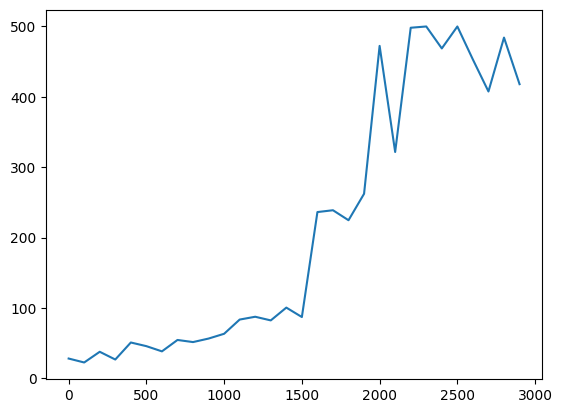

In [8]:
plt.plot(np.arange(0,len(steptest)*100, 100), np.array(steptest))
